In [ ]:

%%capture 
!pip install lightgbm==3.2.1

In [ ]:
#Import libraries
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import numpy as np
from datetime import datetime
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV, cross_val_score, train_test_split #For splitting
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import metrics
import lightgbm as lgb
#from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder,OneHotEncoder # for encoding categorical variables

pd.set_option('max_column', 10000)
pd.set_option('max_row', 10000)


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Mount my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read datasets
path = '/content/drive/MyDrive/DSN HACKATHON 2021/' #This is the path for of the folder where the datasets is stored in Drive
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')

In [ ]:
#Shape of the train and test set
print(f'The Size of the train set is: {train.shape}, and the size of test shape is : {test.shape}')

The Size of the train set is: (1568, 27), and the size of test shape is : (672, 26)


In [ ]:
#Read the first 5 columns of the train set
train.head()

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,22-06-2014,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,01-08-2013,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,21-11-2013,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,13-09-2013,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,21-01-2014,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0


In [ ]:
#Read the first 5 columns of the test shape
test.head()

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain
0,ID_ZPMABNVX,1954,Graduation,Single,48556.8,0,1,11-01-2013,85,6,8,2,8,429,20,118,7,23,41,8,0,0,0,0,0,0
1,ID_WFE91NAA,1961,Graduation,Widow,57499.2,0,1,22-11-2012,79,5,7,4,6,510,3,26,0,0,75,6,0,1,0,0,0,0
2,ID_JV11RBRK,1973,Basic,Married,17025.6,0,0,28-02-2013,47,1,2,0,4,7,10,11,16,12,27,6,0,0,0,0,0,0
3,ID_6B7SVKY9,1970,Graduation,Together,91983.6,0,0,16-08-2013,98,1,4,7,11,741,66,946,219,189,126,2,0,0,1,1,0,0
4,ID_GOVUZ545,1959,Graduation,Together,78235.2,0,2,25-07-2013,41,2,7,6,11,748,22,181,12,0,200,5,1,0,0,0,0,0


In [ ]:
#Create submission file
sub_file = pd.DataFrame(columns=['ID', 'Response'])
sub_file.head() 

,ID,Response


In [ ]:
#Save test ID in a copy for creating submission file later
sub_file.ID = test.ID
sub_file.head()

,ID,Response
0,ID_ZPMABNVX,NaN
1,ID_WFE91NAA,NaN
2,ID_JV11RBRK,NaN
3,ID_6B7SVKY9,NaN
4,ID_GOVUZ545,NaN


In [ ]:
#check for missing values in train set
train.isnull().sum()

In [ ]:
#check for missing values in train set
test.isnull().sum()

In [ ]:
#Check for dtypes in train
train.dtypes

In [ ]:
#Check for dtypes in test
test.dtypes

In [ ]:
#Checking train info
train.info()

In [ ]:

#Checking test info
test.info()

In [ ]:
#Drop ID from train and test
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [ ]:
#Convert Datetime
train['Date_Customer'] = pd.to_datetime(train['Date_Customer'])
test['Date_Customer'] = pd.to_datetime(test['Date_Customer'])
train['Date_Customer'].head()

0   2014-06-22
1   2013-01-08
2   2013-11-21
3   2013-09-13
4   2014-01-21
Name: Date_Customer, dtype: datetime64[ns]

In [ ]:
#Extracting the year, out of customer date
#train year joined
train['Year_Joined'] = pd.to_datetime(train["Date_Customer"]).dt.year
#test year joined
test['Year_Joined'] = pd.to_datetime(test["Date_Customer"]).dt.year

In [ ]:
train.dtypes

In [ ]:
#Drop date customer on train and test set
train.drop('Date_Customer', axis=1, inplace=True)
test.drop('Date_Customer', axis=1, inplace=True)

In [ ]:
# Separating catgorical and numerical column
#categ_cols == categorical columns . Date column excluded
categ_cols = train.select_dtypes(include=['object', 'category']).columns

# num column == numerical columns + date column included
num_cols = [col for col in train.columns if col not in categ_cols]
print(f'The Categorical Columns are: {categ_cols}')
print(f'The Numerical Columns are: {num_cols}')

The Categorical Columns are: Index(['Education_Level', 'Marital_Status'], dtype='object')
The Numerical Columns are: ['Year_of_Birth', 'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home', 'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases', 'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts', 'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth', 'Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted', 'Cmp2Accepted', 'Any_Complain', 'Response', 'Year_Joined']


In [ ]:
#Checking for unique entries in categorical columns in train set
for col in categ_cols:
    print(f'Unique entries in the {col} column in the train set is: {train[col].nunique()}')
    print(f'and the unique entries are: {train[col].unique()}')

Unique entries in the Education_Level column in the train set is: 5
and the unique entries are: ['Graduation' '2n Cycle' 'Master' 'PhD' 'Basic']
Unique entries in the Marital_Status column in the train set is: 8
and the unique entries are: ['Divorced' 'Together' 'Single' 'Married' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [ ]:
#Checking for unique entries in categorical columns in test set
for col in categ_cols:
    print(f'Unique entries in the {col} column in the test set is: {test[col].nunique()}')
    print(f'and the unique entries are: {test[col].unique()}')

Unique entries in the Education_Level column in the test set is: 5
and the unique entries are: ['Graduation' 'Basic' 'Master' '2n Cycle' 'PhD']
Unique entries in the Marital_Status column in the test set is: 6
and the unique entries are: ['Single' 'Widow' 'Married' 'Together' 'Divorced' 'Absurd']


In [ ]:
#Unique entries in the response column
print(f'Unique entries in the Target column in  is: {train.Response.nunique()}')
print(f'and the unique entries are: {train.Response.unique()}')

Unique entries in the Target column in  is: 2
and the unique entries are: [0 1]


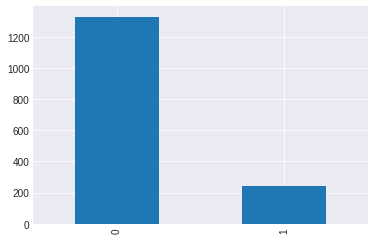

In [ ]:
#Response value counts plot
train.Response.value_counts().plot(kind='bar')

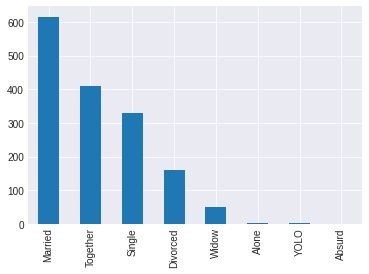

In [ ]:
#Marital status value counts plot
train.Marital_Status.value_counts().plot(kind='bar')

In [ ]:
train['Disposable_Income'].dtype

dtype('float64')

In [ ]:
#Fill in missing values in the disposable income using median
train['Disposable_Income'].fillna((train['Disposable_Income'].mean()) , inplace = True)
#check again to make sure
train.isnull().sum()

In [ ]:
#Fill in missing values in the disposable income using median
test['Disposable_Income'].fillna((test['Disposable_Income'].mean()) , inplace = True)
#check again to make sure
test.isnull().sum()

In [ ]:
#Read train and test again
print(f'The Size of the train set is now: {train.shape}')
train.head()
print(f'The Size of the test set is now: {test.shape}')
test.head()

The Size of the train set is now: (1568, 26)
The Size of the test set is now: (672, 25)


,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Year_Joined
0,1954,Graduation,Single,48556.8,0,1,85,6,8,2,8,429,20,118,7,23,41,8,0,0,0,0,0,0,2013
1,1961,Graduation,Widow,57499.2,0,1,79,5,7,4,6,510,3,26,0,0,75,6,0,1,0,0,0,0,2012
2,1973,Basic,Married,17025.6,0,0,47,1,2,0,4,7,10,11,16,12,27,6,0,0,0,0,0,0,2013
3,1970,Graduation,Together,91983.6,0,0,98,1,4,7,11,741,66,946,219,189,126,2,0,0,1,1,0,0,2013
4,1959,Graduation,Together,78235.2,0,2,41,2,7,6,11,748,22,181,12,0,200,5,1,0,0,0,0,0,2013


In [ ]:
# label encoding 
le = LabelEncoder()
for i in categ_cols:
  train[i] = le.fit_transform(train[i])
  test[i] = le.fit_transform(test[i])
train.head()

,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response,Year_Joined
0,1955,2,2,77504.4,1,1,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0,2014
1,1958,2,5,56784.0,0,1,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0,2013
2,1962,2,4,103714.8,0,0,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1,2013
3,1979,0,4,46311.6,1,0,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0,2013
4,1959,2,3,87486.0,0,0,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0,2014


In [ ]:
#Split into X and y
X = train.drop(['Response'], axis=1)
y = train.Response

In [ ]:
#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Using lightgbm classifier. Loadig and fitting the model
lg = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
lg.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.174006	training's binary_logloss: 0.174006	valid_0's binary_logloss: 0.272476	valid_0's binary_logloss: 0.272476
[40]	training's binary_logloss: 0.0912068	training's binary_logloss: 0.0912068	valid_0's binary_logloss: 0.270996	valid_0's binary_logloss: 0.270996
[60]	training's binary_logloss: 0.0522916	training's binary_logloss: 0.0522916	valid_0's binary_logloss: 0.288832	valid_0's binary_logloss: 0.288832
[80]	training's binary_logloss: 0.0318915	training's binary_logloss: 0.0318915	valid_0's binary_logloss: 0.313574	valid_0's binary_logloss: 0.313574
[100]	training's binary_logloss: 0.0210286	training's binary_logloss: 0.0210286	valid_0's binary_logloss: 0.337733	valid_0's binary_logloss: 0.337733


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.09, max_depth=-5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#LGBM checking for overfitting
print('Training accuracy {:.4f}'.format(lg.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lg.score(X_test,y_test)))

Training accuracy 0.9952
Testing accuracy 0.8885


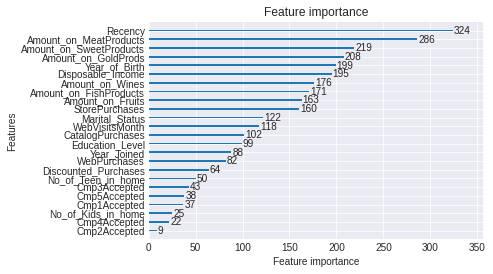

In [ ]:
#Plotting the various feature importance
lgb.plot_importance(lg)

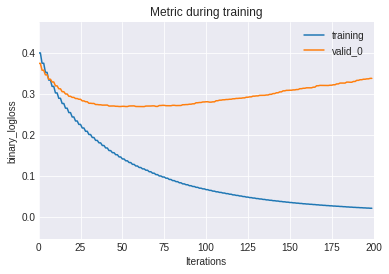

In [ ]:
#Plotting the metric evaluation
lgb.plot_metric(lg)

In [ ]:
#Classification report
print(metrics.classification_report(y_test,lg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       272
           1       0.62      0.43      0.51        42

    accuracy                           0.89       314
   macro avg       0.77      0.69      0.72       314
weighted avg       0.88      0.89      0.88       314



In [ ]:
#Predict on the test set
lg_preds = lg.predict(test)

In [ ]:
#Save prediction to submission file created earlier
sub_file.Response = lg_preds
sub_file.head()

In [ ]:
#Save to CSV for submission
sub_file.to_csv('sapa.lg_preds.csv', index=False)

In [ ]:
#convert to PDF
!pip install notebook-as-pdf

In [ ]:
!python -m pip install -U notebook-as-pdf
!pyppeteer-install

In [ ]:
jupyter-nbconvert --to PDFviaHTML example.ipynb

SyntaxError: ignored